
# Tremor Analysis Using IMU Sensor Data

This notebook analyzes emulated tremor data recorded via an IMU sensor on the **right hand** during various frequency conditions and during voluntrary movements. Our goal is to extract tremor characteristics such as amplitude and frequency over time.

## Data Collection

We recorded IMU data using a [device/model] placed on the right wrist. The dataset includes:
- **Emulated tremor** across a range of frequencies
- **Different movements**, such as static rest tremor at 3 Hz, frequency-
switching rest tremor from 2 to 4 Hz, postural action tremor
while holding the arms bent at 3 Hz, and kinetic action tremor
during functional tasks such as moving blocks on a table
at 3 Hz.

The recordings were sampled at 60 Hz, and include acceleration, gyroscopic data along 3 axes (x, y, z) And tri-axial orientation data is provided by internal sensor fusion..

## Data Structure and Loading

The IMU data is stored in `.h5` format and contains recordings from multiple sensors. We begin by listing all available IMU devices, selecting one (e.g., `imus[1]`), and loading:

- **Accelerometer**: 3-axis acceleration (m/s²)
- **Gyroscope**: 3-axis angular velocity (°/s)
- **Orientation**: 3-axis orientation estimate (degrees)
- **Timestamp**: Corresponding UNIX time stamp values (seconds)

In [80]:
from utils import *

In [81]:
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/3Hz_trial2/IMU.h5'
#path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial2/IMU.h5'

# List all IMUs
imus = get_imu_names(path)
print("Available IMUs:", imus)

# List keys of a specific IMU
if imus:
    keys = get_imu_keys(path, imus[1])
    print(f"Keys in {imus[1]}:", keys)

Available IMUs: ['DOT_40195BF3804A007F', 'DOT_40195BF3804A00D3', 'DOT_40195BF3809B008E', 'DOT_40195BFD80280018', 'DOT_40195BFD8029002F', 'DOT_40195BFD8029003C', 'DOT_40195BFD802900B5']
Keys in DOT_40195BF3804A00D3: ['Accelerometer', 'Gyroscope', 'Orientation', 'Quaternion', 'SeqID', 'Timestamp_Sensor', 'Timestamp_System']


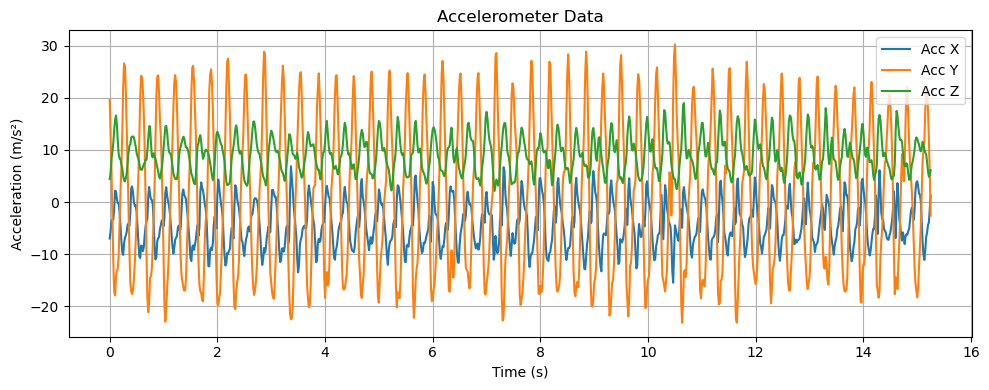

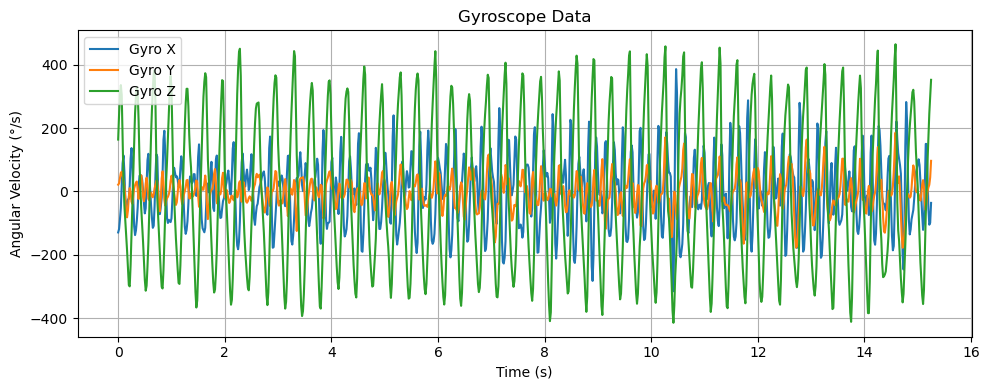

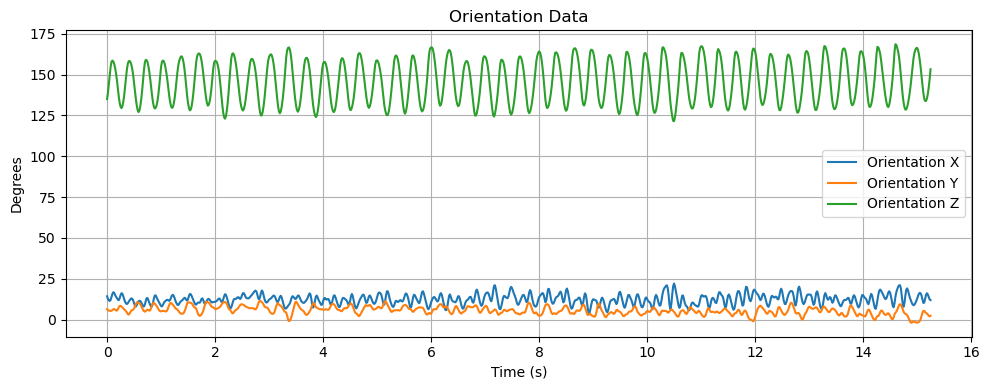

In [82]:
acc, gyro, orient, time = load_imu_data(path, imus[1])
plot_imu_data(acc, gyro, orient, time)

## Preprocessing the IMU Signal

Before analyzing tremor dynamics, we preprocess the raw accelerometer data to ensure clean and interpretable signals. The preprocessing steps include:

- **Detrending**: Removes any slow linear drift in the signal, which could distort frequency analysis.
- **Centering**: Subtracts the mean from the signal to center it around zero, allowing clearer spectral peaks.

These steps help suppress low-frequency artifacts and enhance the visibility of tremor-related frequencies in the subsequent analysis.

## Frequency Analysis using FFT and Harmonics

We analyze the frequency content of the tremor using the **Fast Fourier Transform (FFT)**:

- The FFT transforms the time-domain acceleration signal into the frequency domain.
- We visualize the magnitude spectrum to identify the **dominant frequency**, which typically corresponds to the tremor frequency.

### Harmonics in Tremor Signals

Tremor signals are often not purely sinusoidal—they can contain **higher-frequency components** known as *harmonics*, especially if the tremor has a non-sinusoidal (e.g., sawtooth-like or jagged) shape. For example, a tremor oscillating at 3 Hz may exhibit additional peaks at 6 Hz, 9 Hz, etc.

We therefore:
- Detect the **fundamental tremor frequency** (largest peak, ignoring DC)
- Highlight up to 3 harmonic frequencies to capture the full spectral structure


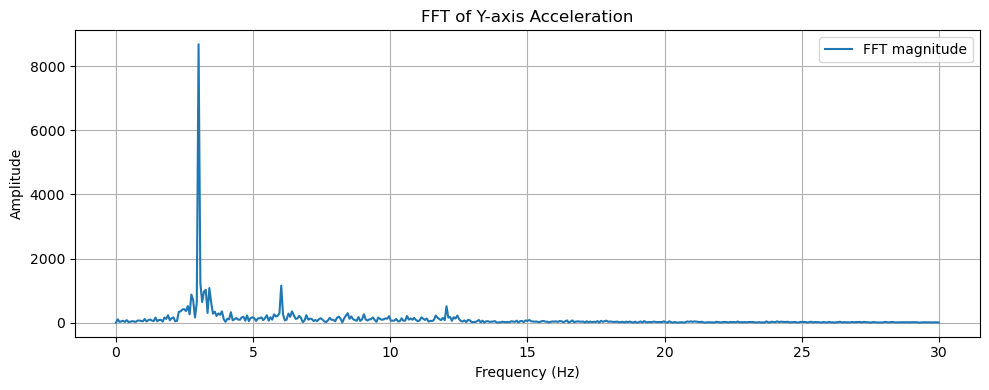

In [83]:
y_axis_signal = acc[1]
signal_clean = preprocess_signal(y_axis_signal)
freqs, fft_vals = compute_fft(signal_clean, fs=60)
plot_fft(freqs, fft_vals, title="FFT of Y-axis Acceleration")

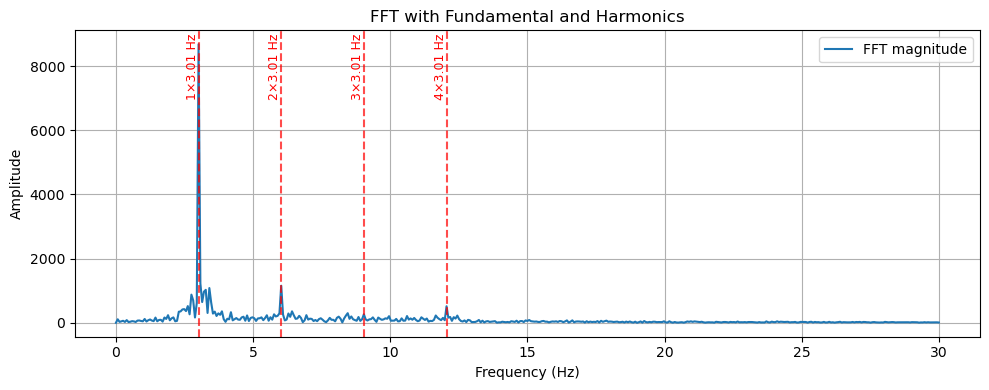

Fundamental frequency: 3.01 Hz


In [84]:
# Example using Y-axis accelerometer data
fund_freq = analyze_fft_with_harmonics(acc[1], fs=60, n_harmonics=4)
print(f"Fundamental frequency: {fund_freq:.2f} Hz")

## Transforming IMU Data into the World Frame and Analyzing Tremor with Wavelets

To better understand the tremor dynamics, we first **transform the accelerometer data from the device frame into the world frame** using orientation information:

- The IMU provides orientation as **Euler angles** (roll, pitch, yaw), which we convert to **rotation matrices**.
- We then **rotate the 3D acceleration vectors** accordingly, aligning them with a consistent external (world) coordinate system.
- After transformation, we **subtract gravity** (approximated as [0, 0, 9.81] m/s²), isolating true movement-induced acceleration.

### Continuous Wavelet Transform Spectrogram

After isolating the tremor signal along the most relevant axis (e.g., Y-axis), we apply a **Continuous Wavelet Transform**:

- The CWT allows **time–frequency analysis**, capturing how the tremor frequency evolves over time.
- Unlike FFT, which gives a global frequency snapshot, CWT shows **when** specific frequency components are active.
- The spectrogram highlights **bursts or shifts** in tremor frequency during different phases of movement.
- It reveals whether tremor is stable or **modulated over time**, which is crucial for characterizing real vs. emulated tremor, assessing intervention effects, or developing control algorithms.

The resulting plot shows:
- Time on the x-axis
- Frequency on the y-axis (up to 10 Hz)
- Color intensity representing signal amplitude at each frequency and time point

## Converting Wavelet Scales to Frequencies in the CWT Spectrogram

When analyzing tremor signals using CWT, the raw output is computed over a range of **scales** — abstract units that relate to frequency, but are not directly interpretable.

To make the spectrogram meaningful in terms of real-world time and frequency, we **convert these wavelet scales to actual frequency values in Hz** using the known relationship for the Morlet wavelet:

$f \approx \frac{f_s}{w \cdot \text{scale}}$

Where:
- \( f \) is the frequency in Hz,
- \( f_s \) is the sampling frequency (e.g., 60 Hz),
- \( w \) is the wavelet width (controls frequency resolution),
- and `scale` is the wavelet scale index.

This transformation allows us to:
- Interpret the **vertical axis of the spectrogram as real frequency** (Hz),
- Analyze how tremor **frequency content evolves over time**, and
- Easily identify **dominant tremor bands** and their changes.


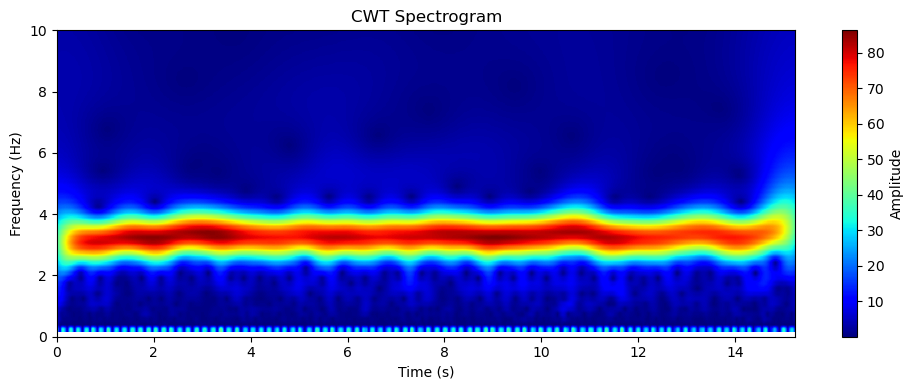

In [85]:
from scipy.spatial.transform import Rotation as R
import numpy as np


# Transpose to shape (N, 3)
acc = acc.T
orient = orient.T

# Compute rotation matrices from orientation (Euler angles in degrees)
rot = R.from_euler('xyz', orient, degrees=True)

# Rotate acceleration into world frame
acc_world = rot.apply(acc)

# Subtract gravity (assuming gravity vector is [0, 0, 9.81])
acc_world -= np.array([0, 0, 9.81])
# Choose one axis (e.g., Y-axis of tremor_band or acc_world)
signal = acc_world[:, 1]  # Y-axis
signal = signal - np.mean(signal)  # Remove DC offset
cwt_matrix, freqs = analyze_cwt_spectrogram(signal, time, fs=60, max_freq=10)



In the CWT spectrogram of our tremor signal, we observe peaks at the expected tremor frequency (e.g., 3 Hz). The CWT provides a visualization of the frequncy components as a function of time. In this case nicely visualizing a static fundamental frequency at 3Hz.

Based on the combined insights from the FFT and CWT analyses, we apply a bandpass filter with cutoff frequencies at 2 Hz and 4 Hz to isolate the tremor component for our further analysis.

Tremor Direction Estimation and Hilbert Analysis

To further characterize the tremor, we first isolate its frequency band and analyze its direction and temporal dynamics using the following steps:

1. Bandpass Filtering

We apply a bandpass filter to the 3-axis acceleration signal with a passband of 2–4 Hz. This isolates the dominant tremor frequency while suppressing slower movements and high-frequency noise. The resulting signal is referred to as the tremor band.

2. Estimating Tremor Direction via PCA

We apply Principal Component Analysis over short sliding windows to estimate the dominant direction of tremor over time. PCA identifies the axis along which the tremor oscillation has the most variance. The resulting 3D direction vectors (X, Y, Z components) describe the orientation of the tremor movement as it evolves.
	•	The plot shows how the X, Y, and Z components of the dominant tremor direction vary over time.
	•	This helps us assess whether the tremor is directionally stable (e.g., always aligned with one axis) or fluctuates during the recording.

3. Hilbert Transform for Envelope and Phase

We apply the Hilbert transform to the filtered tremor band to extract:
	•	The envelope, representing the instantaneous tremor amplitude (how strong the tremor is at each moment).

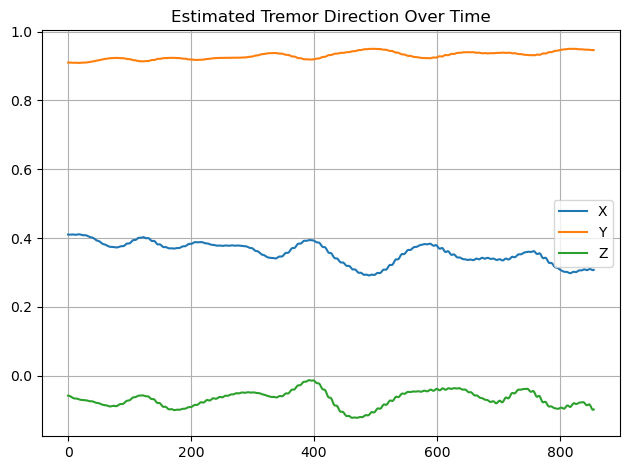

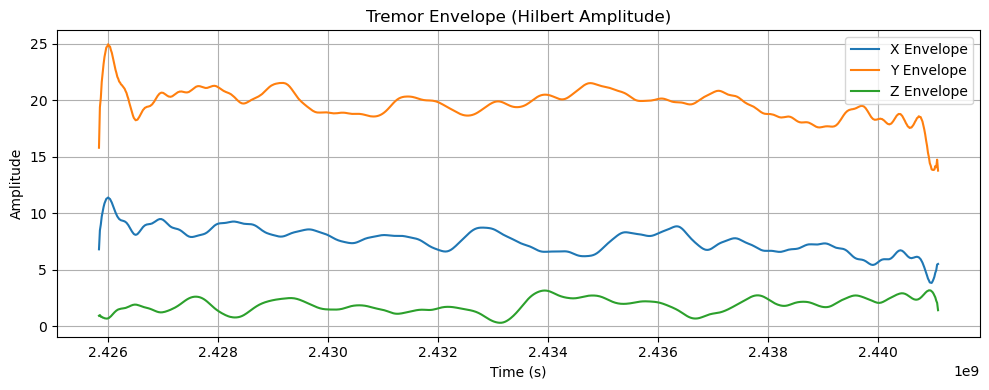

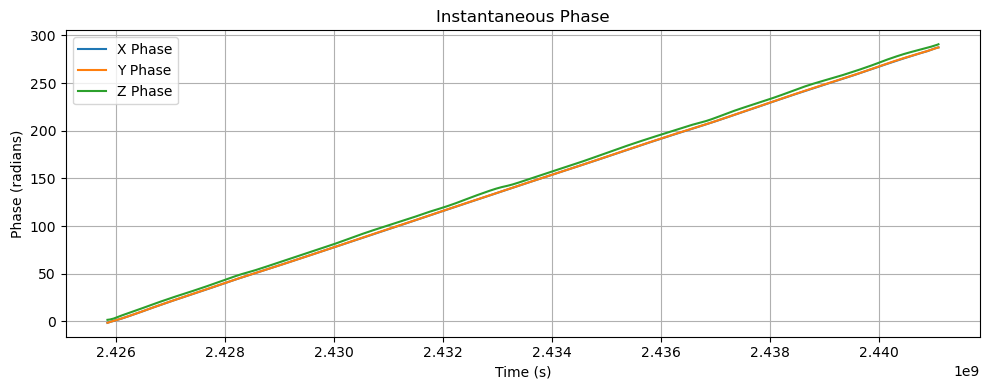

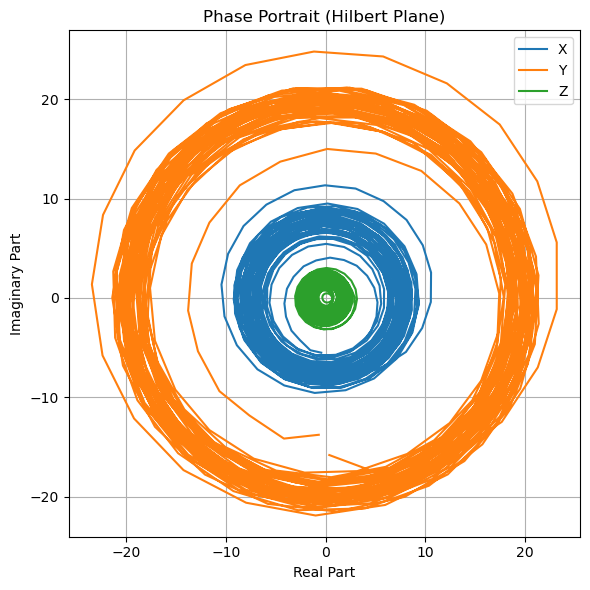

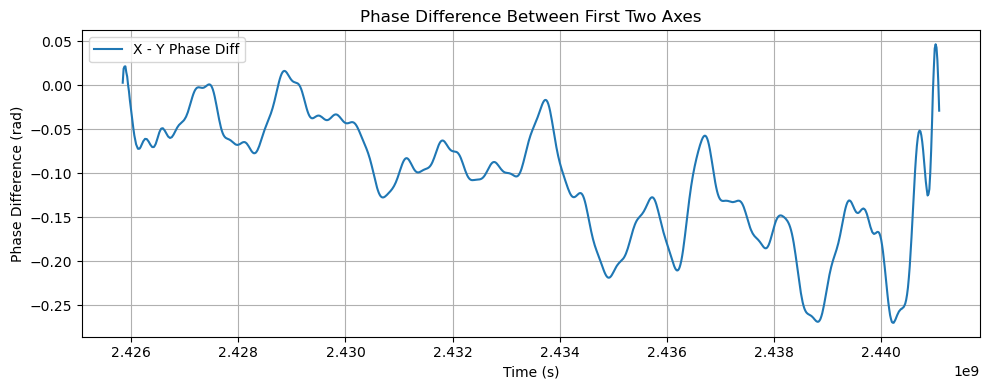

In [86]:
# Filter the raw acceleration to get tremor band
tremor_band = bandpass_filter(acc_world, lowcut=2, highcut=4, fs=60)

# Estimate tremor direction (dominant axis over time)
tremor_dir_vectors = estimate_tremor_direction_pca(tremor_band, fs=60)

# Plot tremor direction over time
import matplotlib.pyplot as plt
plt.plot(tremor_dir_vectors[:, 0], label='X')
plt.plot(tremor_dir_vectors[:, 1], label='Y')
plt.plot(tremor_dir_vectors[:, 2], label='Z')
plt.title("Estimated Tremor Direction Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply Hilbert transform and analyze envelope & phase (on filtered tremor_band!)
envelope, phase, analytic_signal = analyze_tremor_hilbert(
    tremor_band,
    time[:tremor_band.shape[0]], 
    axis_labels=['X', 'Y', 'Z']
)

Both the PCA-based direction estimation and the Hilbert envelope analysis indicate that the tremor exhibits maximum amplitude along the Y-axis. Specifically, the direction of greatest variance identified by PCA aligns with the Y-axis, which also shows the strongest amplitude in the Hilbert envelope.

This consistent result across two independent methods strongly suggests that the tremor is primarily occurring along the Y-axis

### Loading and Visualizing IMU Data for Tremor Frequency Switch

In this section, we load a new IMU dataset recorded during a trial where the **tremor frequency changes mid-trial** — beginning at 2 Hz and transitioning to 4 Hz.

Available IMUs: ['DOT_40195BF3804A007F', 'DOT_40195BF3804A00D3', 'DOT_40195BF3809B008E', 'DOT_40195BFD80280018', 'DOT_40195BFD8029002F', 'DOT_40195BFD8029003C', 'DOT_40195BFD802900B5']
Keys in DOT_40195BF3804A00D3: ['Accelerometer', 'Gyroscope', 'Orientation', 'Quaternion', 'SeqID', 'Timestamp_Sensor', 'Timestamp_System']


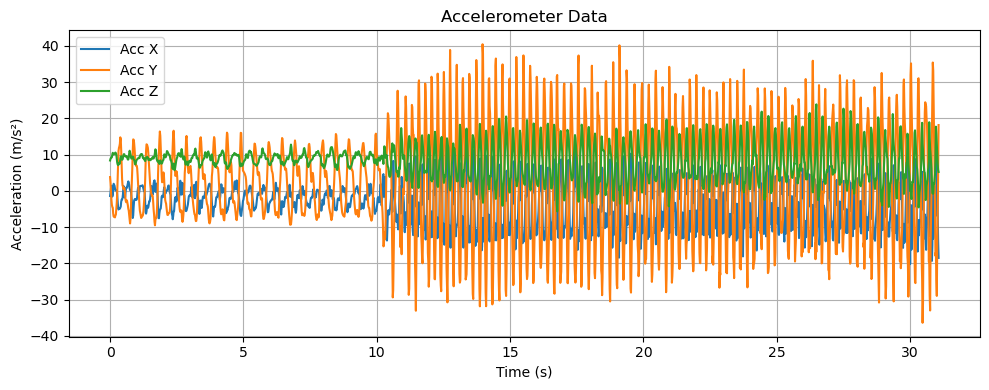

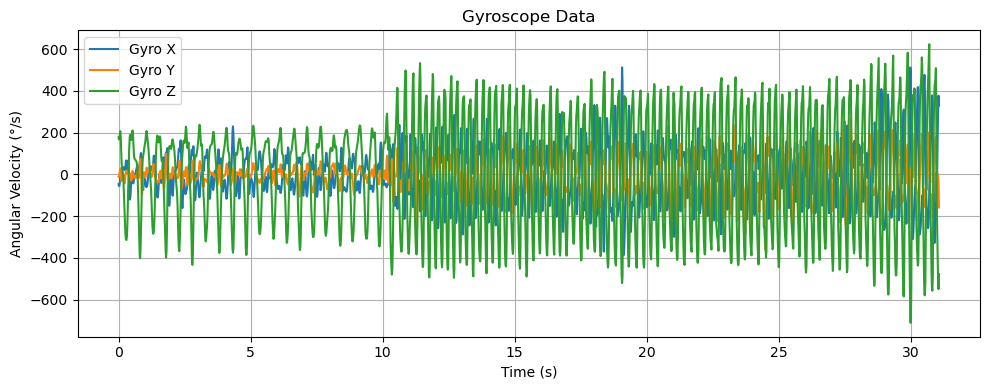

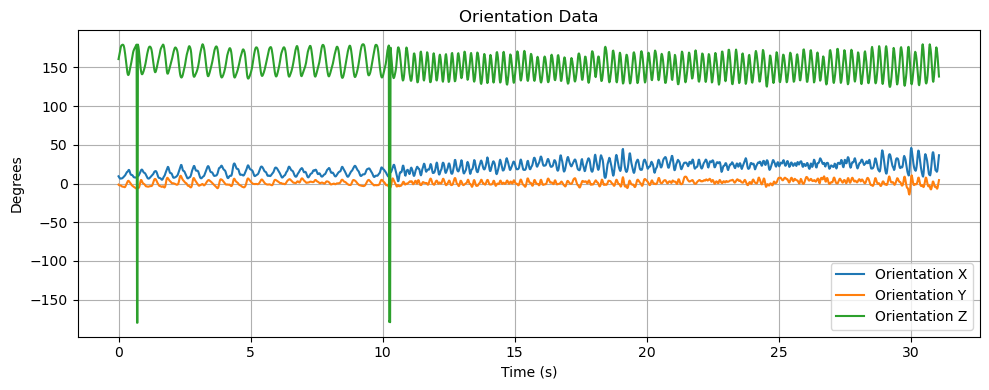

In [87]:
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/2Hz_4Hz_trial1/IMU.h5'

# List all IMUs
imus = get_imu_names(path)
print("Available IMUs:", imus)

# List keys of a specific IMU
if imus:
    keys = get_imu_keys(path, imus[1])
    print(f"Keys in {imus[1]}:", keys)

acc, gyro, orient, time = load_imu_data(path, imus[1])
plot_imu_data(acc, gyro, orient, time)

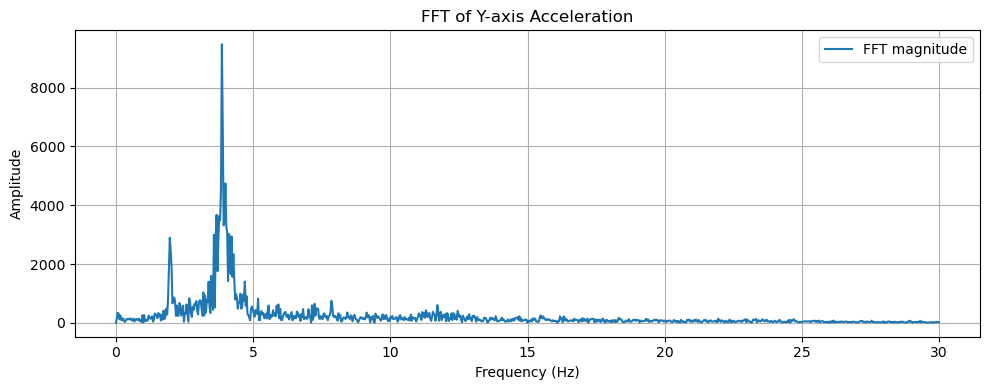

In [88]:
y_axis_signal = acc[1]
signal_clean = preprocess_signal(y_axis_signal)
freqs, fft_vals = compute_fft(signal_clean, fs=60)
plot_fft(freqs, fft_vals, title="FFT of Y-axis Acceleration")

### Kalman Filter Bank for Tremor Frequency Tracking and Harmonic Scoring

This section implements a **Kalman filter bank spectrogram** to estimate tremor frequency over time. Unlike FFT or CWT, this approach tracks power in narrowband sinusoids using adaptive estimation, making it especially useful for **nonstationary signals** like tremor with possible frequency changes.

#### Steps:

1. **Bandpass Preprocessing**  
   The raw tremor signal is first filtered between 1–10 Hz to isolate physiologically plausible tremor components.

2. **Kalman Filter Bank Spectrogram**  
   A set of Kalman filters—each tuned to a different frequency—is used to track the power at that frequency over time. For each frequency bin:
   - The signal is projected onto sinusoids at that frequency.
   - A 2D Kalman filter estimates the sinusoid amplitude.
   - Power is estimated from the amplitude squared.
   - The output is a high-resolution time–frequency matrix `spec`.

3. **Harmonic Scoring**  
   For each time point, the algorithm scores frequencies not just by raw power but by the presence of their **harmonics** (e.g., 2×, 3× the base frequency). This helps identify the **true fundamental tremor frequency**, which may not always have the strongest peak but exhibits harmonic structure.

4. **Uncertainty Quantification**  
   A power-weighted mean and standard deviation of the frequency are computed to give a **confidence band** around the estimated frequency.

5. **Visualization**  
   Three plots are produced:
   - A spectrogram over time with overlays for:
     - the fundamental frequency (from harmonic scoring),
     - max-power frequency,
     - smoothed peak track.
   - A harmonic score trace over time.
   - A frequency vs. time plot with uncertainty bands.

This approach is helpful for:
- **Tracking frequency changes over time**, such as transitions from 2 Hz to 4 Hz tremor.
- **Robustly identifying the true tremor frequency** based on harmonic structure, not just raw power.
- **Visualizing tremor characteristics** with both interpretability and precision.

It complements FFT and CWT by providing adaptive real-time tracking with both high temporal resolution and harmonic specificity.

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


def preprocess_signal(signal, fs, lowcut=1.0, highcut=10.0):
    """Bandpass filter the input signal between lowcut and highcut Hz."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(3, [low, high], btype='band')
    return filtfilt(b, a, signal)


def kalman_filter_bank_spectrogram(signal, fs, freqs, q=1e-4, r=1e-1,
                                   power_bias=1.5, process_noise_bias=1.5):
    """Estimate time-frequency power via a Kalman filter bank."""
    N = len(signal)
    dt = 1 / fs
    spec = np.zeros((len(freqs), N))
    uncertainty = np.zeros((len(freqs), N))

    for i, f in enumerate(freqs):
        omega = 2 * np.pi * f
        x = np.zeros(2)
        P = np.eye(2)
        Q = (q / (f**process_noise_bias)) * np.eye(2)
        R = r

        for k in range(N):
            H = np.array([np.cos(omega * k * dt), np.sin(omega * k * dt)]).reshape(1, -1)
            y = signal[k]

            x_pred = x
            P_pred = P + Q

            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T / S
            x = x_pred + (K.flatten() * (y - H @ x_pred)).flatten()
            P = (np.eye(2) - K @ H) @ P_pred

            power = np.sum(x ** 2) / (f**power_bias)
            spec[i, k] = power
            uncertainty[i, k] = np.trace(P)

    return spec, uncertainty


def harmonic_score_column(spec_col, freqs, max_harmonics=4, threshold=0.5):
    scores = []
    f_max = freqs[-1]
    for i, f in enumerate(freqs):
        harmonics = []
        for h in range(1, max_harmonics + 1):
            f_h = f * h
            if f_h > f_max:
                continue
            idx = np.argmin(np.abs(freqs - f_h))
            if idx < len(spec_col) and spec_col[idx] > threshold:
                harmonics.append(spec_col[idx] / h**2)
        scores.append(np.sum(harmonics) if harmonics else 0.0)
    return scores


def extract_fundamental_from_spec(spec, freqs, fs, max_harmonics=4, threshold=0.5):
    fundamental_freqs = []
    all_scores = []
    for k in range(spec.shape[1]):
        spec_col = spec[:, k]
        scores = harmonic_score_column(spec_col, freqs, max_harmonics=max_harmonics, threshold=threshold)
        best_idx = np.argmax(scores)
        fundamental_freqs.append(freqs[best_idx])
        all_scores.append(scores)
    return np.array(fundamental_freqs), np.array(all_scores)


def compute_frequency_uncertainty(spec, freqs):
    """Compute power-weighted mean and std deviation of frequency."""
    spec_sum = np.sum(spec, axis=0, keepdims=True) + 1e-10
    weights = spec / spec_sum
    mean_freqs = np.sum(weights * freqs[:, None], axis=0)
    var_freqs = np.sum(weights * (freqs[:, None] - mean_freqs[None, :])**2, axis=0)
    stddev_freqs = np.sqrt(var_freqs)
    return mean_freqs, stddev_freqs


def plot_all_kalman_analysis(signal, fs, freqs, spec, fundamental_freqs, harmonic_scores, uncertainty):
    t = np.arange(len(signal)) / fs
    max_power_indices = np.argmax(spec, axis=0)
    max_power_freqs = freqs[max_power_indices]
    smoothed_max_freqs = np.convolve(max_power_freqs, np.ones(5)/5, mode='same')
    spec_db = 10 * np.log10(spec / (np.max(spec, axis=0, keepdims=True) + 1e-10))

    # Spectrogram with overlays
    plt.figure(figsize=(12, 5))
    plt.imshow(spec_db, extent=[t[0], t[-1], freqs[0], freqs[-1]], aspect='auto', origin='lower', cmap='viridis')
   # plt.plot(t, fundamental_freqs, 'r-', label='Fundamental (harmonic scoring)')
    #plt.plot(t, max_power_freqs, 'b--', label='Max Power Frequency')
    #plt.plot(t, smoothed_max_freqs, 'g-', label='Smoothed Max Frequency')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Kalman Spectrogram with Harmonic Scoring")
    plt.colorbar(label="Power (dB)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Harmonic scores over time
    plt.figure(figsize=(12, 4))
    plt.plot(t, [np.max(score_row) for score_row in harmonic_scores], 'm-', label='Max Harmonic Score')
    plt.title("Harmonic Score Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Frequency estimate with uncertainty
    mean_freqs, stddev_freqs = compute_frequency_uncertainty(spec, freqs)
    plt.figure(figsize=(12, 4))
    #plt.plot(t, fundamental_freqs, 'r-', label='Fundamental Estimate')
    plt.plot(t, mean_freqs, 'b--', label='Power-Weighted Mean Freq')
    plt.fill_between(t, mean_freqs - stddev_freqs, mean_freqs + stddev_freqs,
                     color='blue', alpha=0.3, label='Uncertainty (±1σ)')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Frequency Estimate with Uncertainty")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


    return smoothed_max_freqs


def run_kalman_tremor_analysis(signal, fs, freq_grid):
    signal_filt = preprocess_signal(signal, fs)
    spec, uncertainty = kalman_filter_bank_spectrogram(signal_filt, fs, freq_grid)
    fundamental_freqs, harmonic_scores = extract_fundamental_from_spec(spec, freq_grid, fs)
    smoothed_max_freqs = plot_all_kalman_analysis(signal_filt, fs, freq_grid, spec, fundamental_freqs, harmonic_scores, uncertainty)
    return spec, fundamental_freqs, harmonic_scores, uncertainty, smoothed_max_freqs

/var/folders/dx/zswlyk812zq8m7h3crzgxx9r0000gn/T/ipykernel_3206/1633853721.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


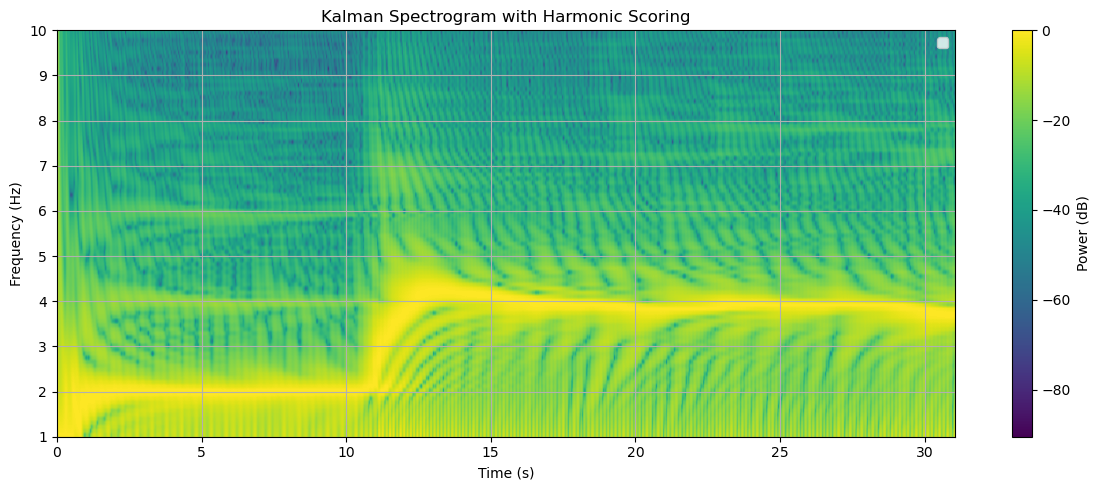

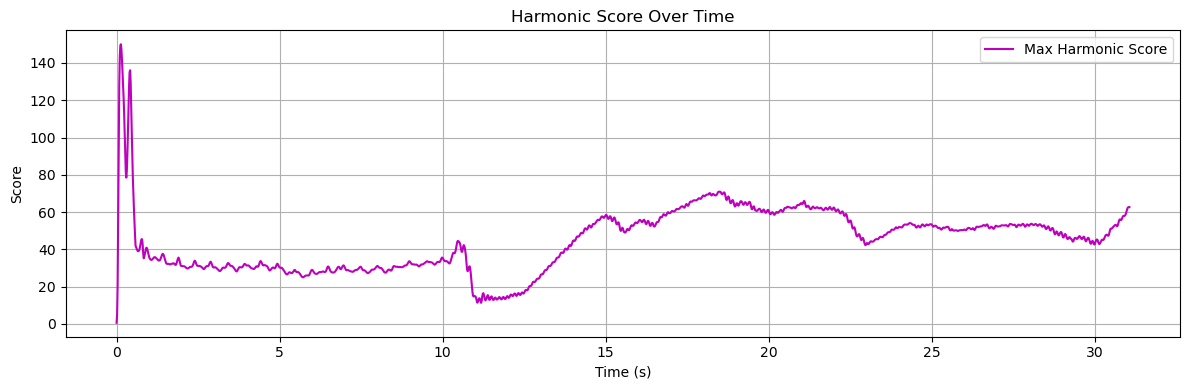

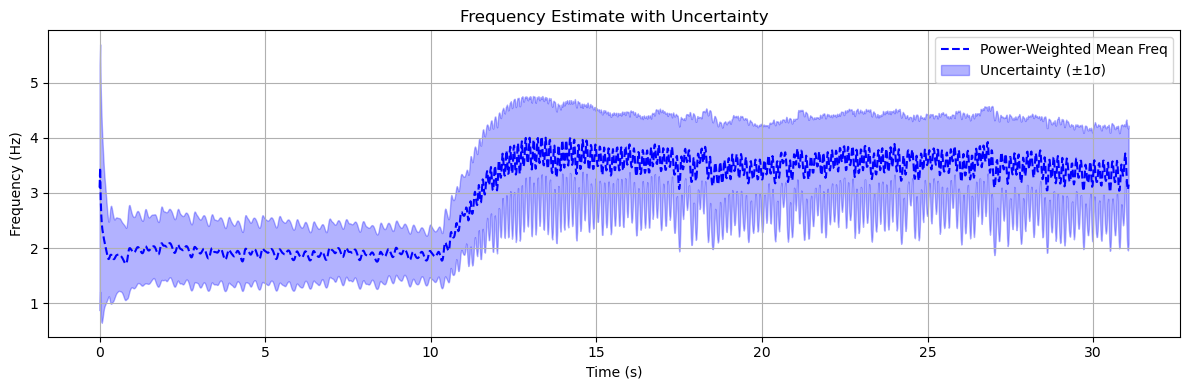

In [90]:
fs = 60
freq_grid = np.linspace(1, 10, 100)
signal = acc[1]  # Y-axis accelerometer

spec, fundamental_freqs, harmonic_scores, uncertainty,smoothed_max_freqs = run_kalman_tremor_analysis(signal, fs, freq_grid)

### Voluntary vs Tremor Movement in Orientation Data

In this section, we analyze the orientation data (Roll, Pitch, and Yaw angles) to separate voluntary and tremor-induced components of movement. This is done by applying a bandpass filter:
	•	Voluntary movement is expected to occur at lower frequencies (0.1–2 Hz).
	•	Tremor movement typically occurs at higher frequencies (3–8 Hz).

We filter the orientation signal into these two bands for each of the three axes (Roll, Pitch, Yaw), and plots them in subplots.


Available IMUs: ['DOT_40195BF3804A007F', 'DOT_40195BF3804A00D3', 'DOT_40195BF3809B008E', 'DOT_40195BFD80280018', 'DOT_40195BFD8029002F', 'DOT_40195BFD8029003C', 'DOT_40195BFD802900B5']
Keys in DOT_40195BF3804A00D3: ['Accelerometer', 'Gyroscope', 'Orientation', 'Quaternion', 'SeqID', 'Timestamp_Sensor', 'Timestamp_System']


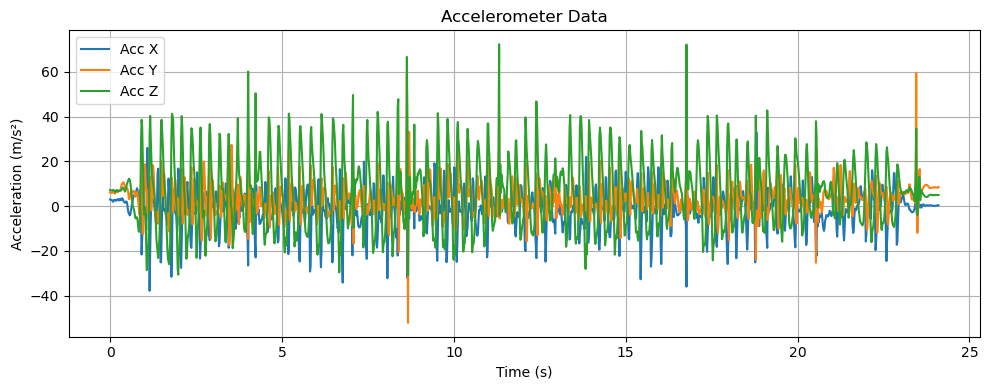

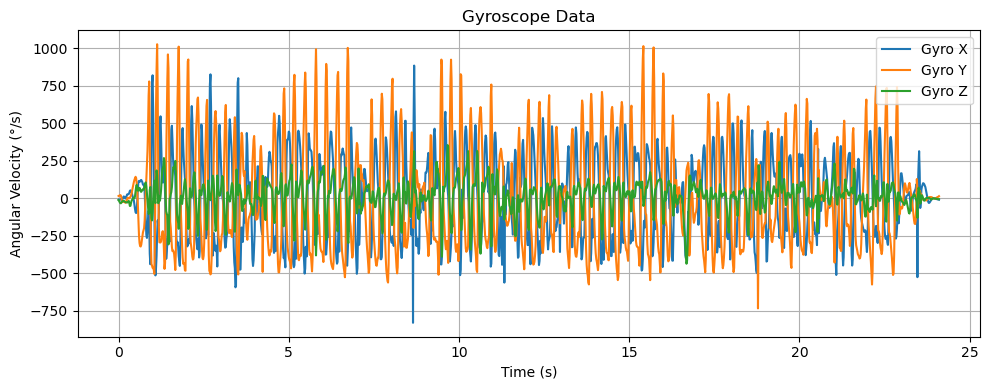

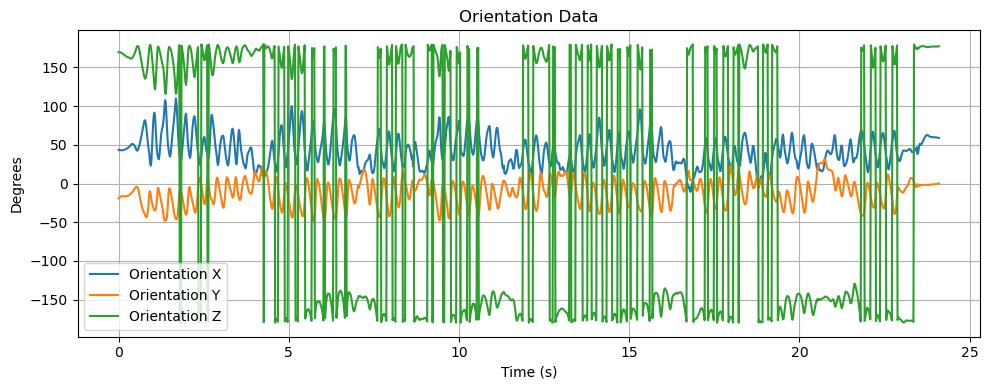

In [91]:
path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/Brick1_3Hz_trial1/IMU.h5'
#path = '/Users/alinakrause/Downloads/Student_project_motion_in_human_and_machine_seminar/Student_test/3Hz_trial2/IMU.h5'

# List all IMUs
imus = get_imu_names(path)
print("Available IMUs:", imus)

# List keys of a specific IMU
if imus:
    keys = get_imu_keys(path, imus[1])
    print(f"Keys in {imus[1]}:", keys)

acc, gyro, orient, time = load_imu_data(path, imus[1])
plot_imu_data(acc, gyro, orient, time)


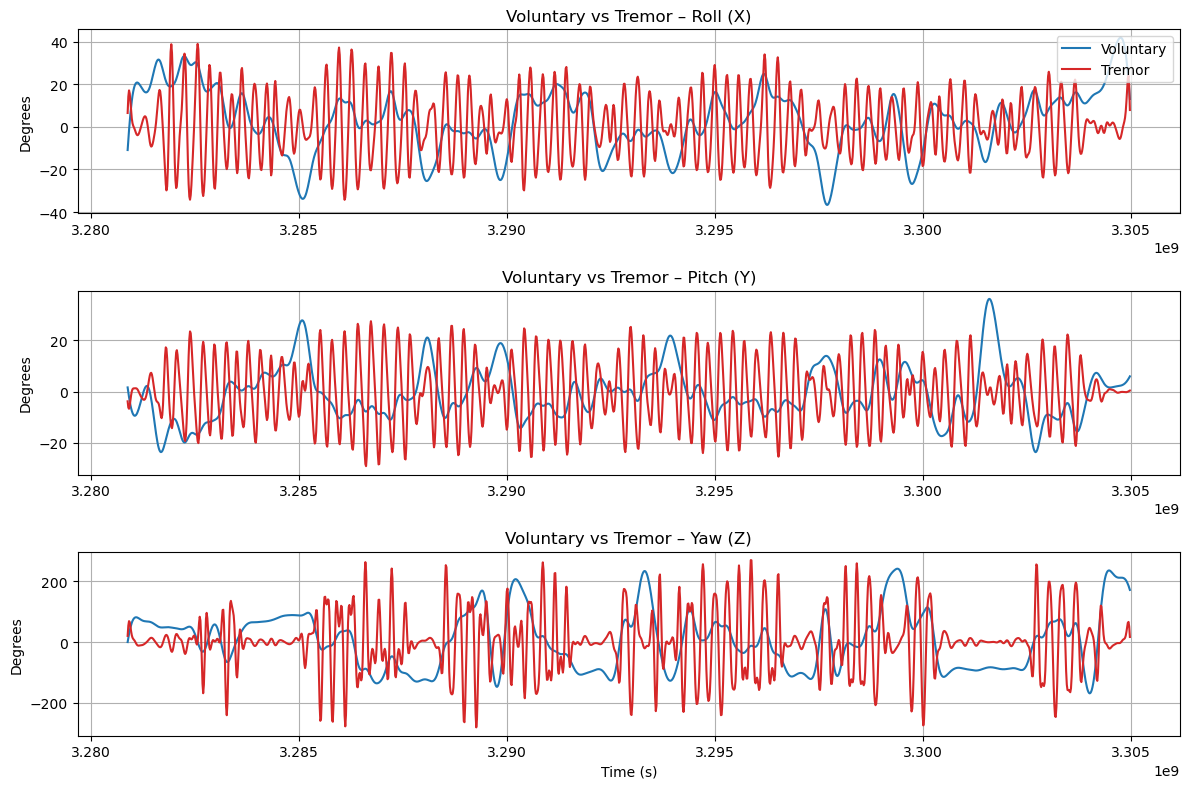

In [93]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np

def bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    
    
    return filtfilt(b, a, data, axis=0, method='gust')

def plot_orientation_voluntary_tremor(orient, time, fs=60):
    if orient.shape[0] < 30:
        raise ValueError("Orientation signal too short for filtering.")

    # Apply bandpass filters for voluntary and tremor movement
    voluntary_orient = bandpass_filter(orient, lowcut=0.1, highcut=2, fs=fs)
    tremor_orient = bandpass_filter(orient, lowcut=2, highcut=8, fs=fs)

    axes_labels = ['Roll (X)', 'Pitch (Y)', 'Yaw (Z)']
    
    plt.figure(figsize=(12, 8))
    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.plot(time, voluntary_orient[:, i], label='Voluntary', color='tab:blue')
        plt.plot(time, tremor_orient[:, i], label='Tremor', color='tab:red')
        plt.ylabel("Degrees")
        plt.title(f"Voluntary vs Tremor – {axes_labels[i]}")
        plt.grid(True)
        if i == 0:
            plt.legend(loc='upper right')
        if i == 2:
            plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

plot_orientation_voluntary_tremor(orient.T, time, fs=60)
#plot_orientation_voluntary_tremor(gyro.T, time, fs=60)
#plot_orientation_voluntary_tremor(acc_preprocessed, time, fs=60)


## Plot Interpretation

Each subplot shows the filtered orientation signal over time:

- **Blue line**: Voluntary movement component (low frequency)  
- **Red line**: Tremor component (high frequency)  

By separating voluntary and tremor movements:

- We can better understand which axes are affected by tremor.  
- This helps in designing tremor suppression systems (e.g., filters, assistive devices) by targeting the dominant tremor direction.  
- We also gain insight into user intent vs. involuntary motion, aiding in control or classification tasks.